# Proof of concept for using crosstalk to manipulate output of circuit on hw

## imports

In [1]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)

from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

from qiskit.visualization import plot_histogram

## create fake device (here: ibm_sherbrooke)

In [2]:
fake_backend = FakeSherbrooke()

In [3]:
print(fake_backend.coupling_map)

[[1, 0], [1, 2], [3, 2], [4, 3], [4, 15], [5, 4], [6, 5], [7, 6], [8, 7], [8, 9], [10, 9], [10, 11], [11, 12], [12, 13], [14, 0], [14, 18], [16, 8], [17, 12], [17, 30], [18, 19], [19, 20], [20, 33], [21, 20], [21, 22], [22, 15], [23, 22], [23, 24], [25, 24], [26, 16], [26, 25], [26, 27], [28, 27], [29, 28], [29, 30], [31, 30], [31, 32], [32, 36], [33, 39], [34, 24], [35, 28], [35, 47], [36, 51], [37, 38], [38, 39], [40, 39], [41, 40], [41, 53], [42, 41], [43, 34], [43, 42], [43, 44], [45, 44], [45, 46], [47, 46], [47, 48], [49, 48], [49, 50], [50, 51], [52, 37], [53, 60], [54, 45], [55, 49], [56, 52], [56, 57], [57, 58], [59, 58], [59, 60], [61, 60], [61, 62], [63, 62], [63, 64], [64, 54], [64, 65], [66, 65], [67, 66], [68, 55], [68, 67], [69, 68], [69, 70], [71, 58], [71, 77], [72, 62], [73, 66], [73, 85], [74, 70], [75, 76], [77, 76], [78, 77], [78, 79], [79, 91], [80, 79], [80, 81], [81, 72], [81, 82], [82, 83], [84, 83], [85, 84], [86, 85], [86, 87], [87, 88], [89, 74], [89, 88], [

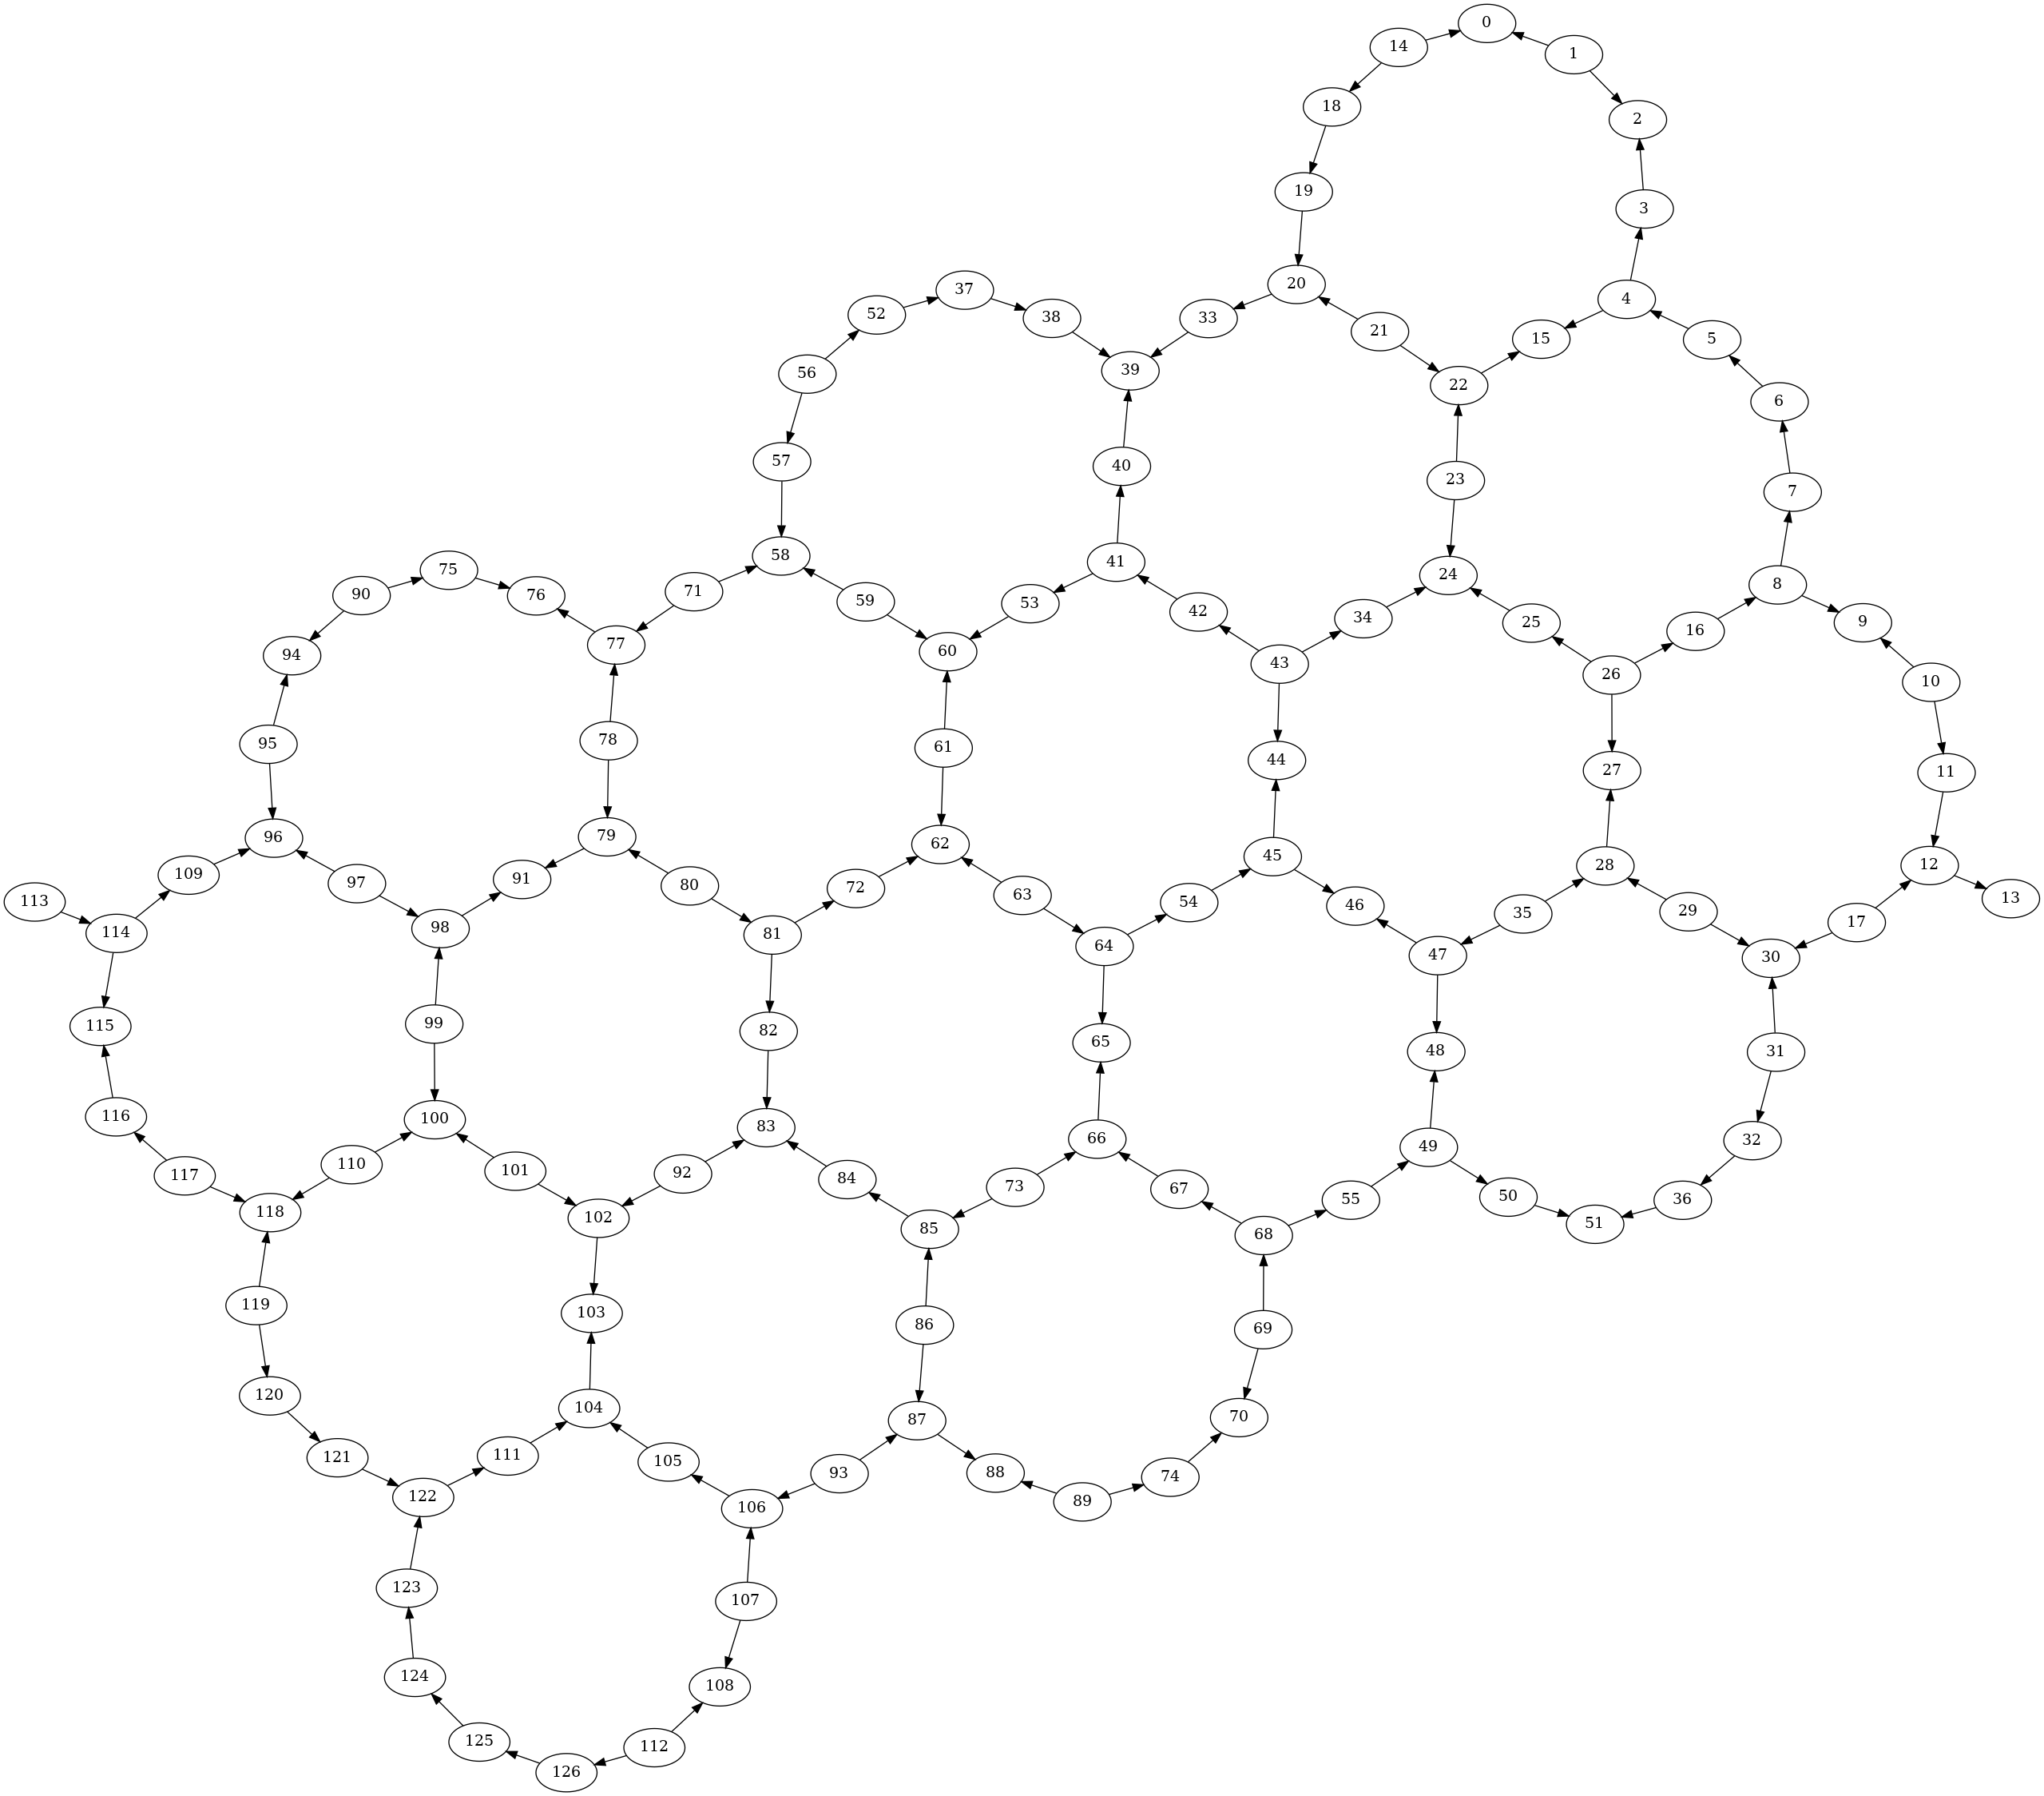

In [4]:
fake_backend.coupling_map.draw()

## define our dummy circuit

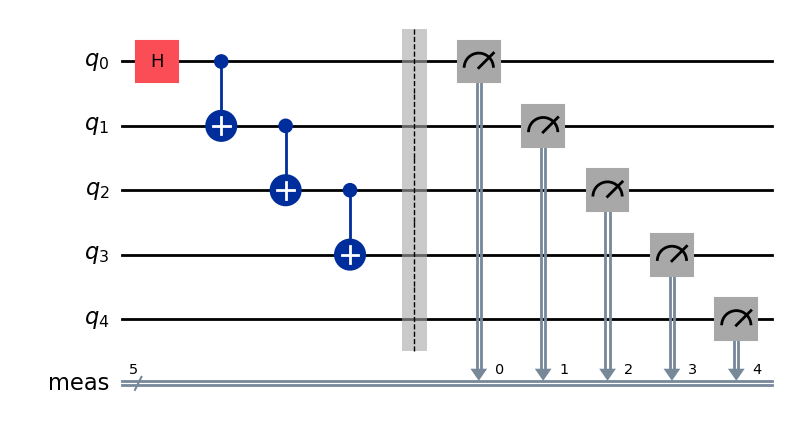

In [5]:
# Make a quantum circuit -> GHZ state
qc = QuantumCircuit(5)#Add your code
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.measure_all()

qc.draw("mpl")

## use fake backend

In [6]:
sampler = Sampler(fake_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend=fake_backend, seed_transpiler=0)

In [7]:
qc_isa = pm.run(qc)

In [8]:
pub = (qc_isa)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00000': 467, '01111': 442, '00100': 16, '00010': 8, '01101': 8, '10000': 4, '01000': 5, '00101': 1, '00111': 9, '01110': 6, '01011': 9, '11111': 5, '00001': 13, '00011': 4, '01100': 2, '11011': 1}


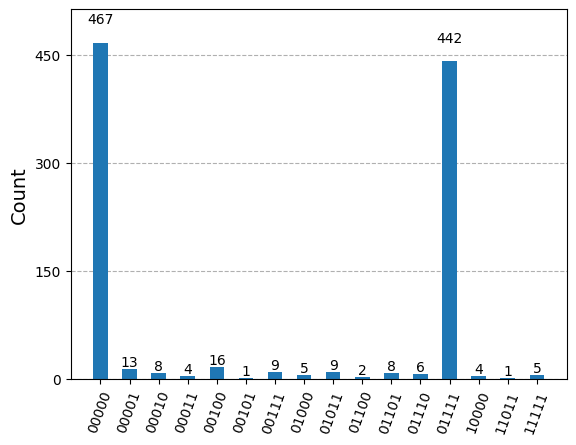

In [9]:
plot_histogram(counts_sampler)

## use real backend

In [10]:
# init account and get backend
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
real_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

In [11]:
sampler = Sampler(real_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend=real_backend, seed_transpiler=0)

In [12]:
qc_isa_real = pm.run(qc)

In [13]:
pub = (qc_isa_real)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01111': 319, '11111': 41, '00000': 370, '01110': 17, '00001': 23, '10111': 64, '11001': 2, '10000': 30, '01000': 22, '10101': 4, '00011': 13, '11000': 3, '01011': 16, '11101': 3, '00010': 2, '00101': 2, '10011': 6, '10100': 4, '11100': 2, '01100': 9, '00100': 11, '11011': 2, '01101': 10, '00111': 22, '10110': 2, '11110': 1}


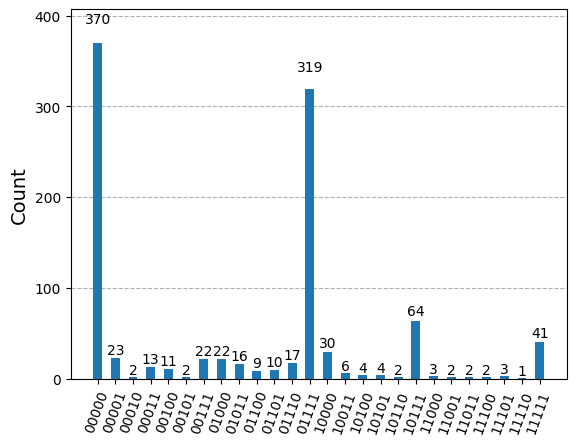

In [14]:
plot_histogram(counts_sampler)

## manipulate circuit 1q-gate on hw

In [15]:
qc_manipulate = QuantumCircuit(5,5)

In [16]:
for i in range(0,10000):
    qc_manipulate.h(4)

In [17]:
qc_manipulate = qc_manipulate.compose(qc)
qc_manipulate.measure_all()

In [18]:
#qc_manipulate.draw("mpl")

In [19]:
qc_isa_tempered = pm.run(qc_manipulate)

In [20]:
#qc_isa_tempered.draw("mpl")

In [21]:
pub = (qc_isa_tempered)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'10001': 5, '10000': 87, '00000': 320, '01111': 196, '11111': 119, '10111': 91, '01011': 9, '01000': 58, '10110': 3, '00011': 6, '11101': 10, '01001': 3, '11000': 5, '00101': 1, '11110': 9, '10100': 2, '01101': 9, '00111': 15, '10011': 3, '10010': 2, '01110': 10, '10101': 4, '00001': 13, '01100': 7, '00010': 4, '11100': 3, '11011': 3, '00100': 2, '00110': 1}


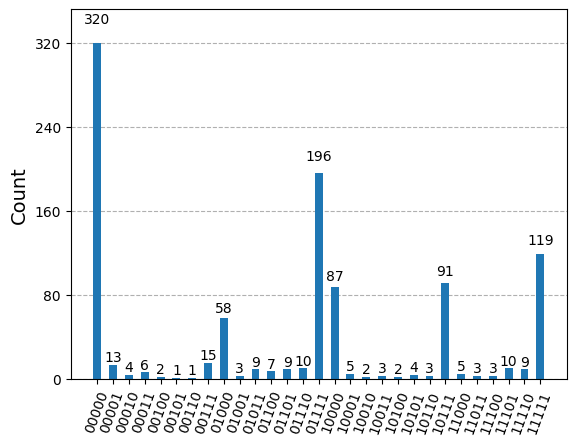

In [22]:
plot_histogram(counts_sampler)

## manipulate circuit 2q-gate on hw

In [23]:
qc_manipulate2 = QuantumCircuit(5,5)

In [24]:
for i in range(0,1000):
    qc_manipulate2.cx(3,4)

In [25]:
qc_manipulate2 = qc_manipulate2.compose(qc)
qc_manipulate2.measure_all()

In [26]:
qc_isa_tempered2 = pm.run(qc_manipulate2)

In [27]:
pub = (qc_isa_tempered2)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'11111': 125, '11000': 105, '10111': 87, '10000': 81, '10011': 5, '01111': 118, '10001': 11, '00000': 113, '00111': 107, '01011': 15, '01101': 6, '01100': 1, '01000': 121, '01010': 4, '00011': 13, '11011': 9, '11100': 4, '01110': 10, '10010': 2, '10101': 6, '11001': 8, '01001': 8, '00001': 8, '00010': 1, '11101': 3, '10100': 6, '11110': 6, '00100': 7, '10110': 4, '00110': 2, '11010': 3, '00101': 1}


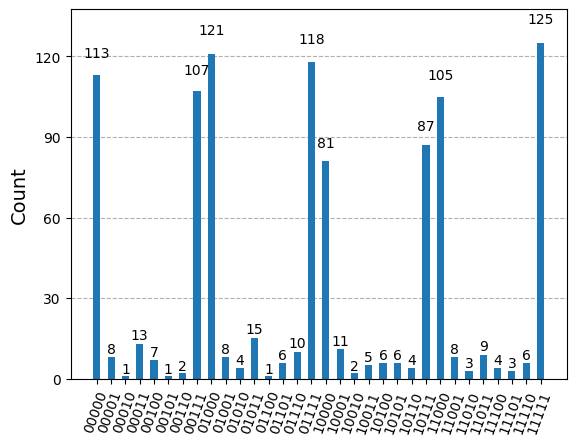

In [28]:
plot_histogram(counts_sampler)